In [1]:
from igm_emulator.scripts.grab_models import param_transform
import dill
import os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import random

# redshift to get models for -- can make this an input to this script if desired
redshift = 5.6
# get the appropriate string and pathlength for chosen redshift
zs = np.array([5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0])
z_idx = np.argmin(np.abs(zs - redshift))
z_strings = ['z54', 'z55', 'z56', 'z57', 'z58', 'z59', 'z6']
z_string = z_strings[z_idx]
n_paths = np.array([17, 16, 16, 15, 15, 15, 14])
n_path = n_paths[z_idx]

# read in the parameter grid at given z
param_in_path = '/mnt/quasar2/mawolfson/correlation_funct/temp_gamma/final/'
param_dict = dill.load(open(param_in_path + f'{z_string}_params.p', 'rb'))
# get the path to the autocorrelation function results from the simulations
in_path = f'/mnt/quasar2/mawolfson/correlation_funct/temp_gamma/final/{z_string}/final_135/'

fobs = param_dict['fobs']  # average observed flux <F> ~ Gamma_HI -9
log_T0s = param_dict['log_T0s']  # log(T_0) from temperature - density relation -15
T0s = np.power(10,log_T0s)
gammas = param_dict['gammas']  # gamma from temperature - density relation -9
print(f'fobs:{fobs}')
print(f'log_T0s: {log_T0s}')
print(f'T0s: {T0s}')
print(f'gammas:{gammas}')


fobs:[0.03  0.035 0.04  0.045 0.05  0.055 0.06  0.065 0.07 ]
log_T0s: [2.8876173  3.30731262 3.51670532 3.6573837  3.76347078 3.84866407
 3.91985479 3.98100269 4.03459408 4.08229286 4.12526744 4.16436985
 4.20024059 4.23337328 4.26415644]
T0s: [  772.          2029.14285714  3286.28571429  4543.42857143
  5800.57142857  7057.71428571  8314.85714286  9572.
 10829.14285714 12086.28571429 13343.42857143 14600.57142857
 15857.71428571 17114.85714286 18372.        ]
gammas:[0.444 0.664 0.884 1.104 1.324 1.544 1.764 1.984 2.204]


[0.03  0.03  0.03  0.03  0.03  0.03  0.03  0.03  0.03  0.035 0.035 0.035
 0.035 0.035 0.035]
[772. 772. 772. 772. 772. 772. 772. 772. 772. 772. 772. 772. 772. 772.
 772.]
[0.444 0.664 0.884 1.104 1.324 1.544 1.764 1.984 2.204 0.444 0.664 0.884
 1.104 1.324 1.544]
(1215, 3)


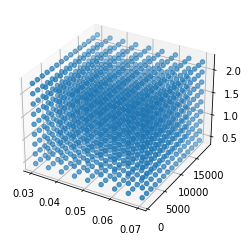

In [2]:
# Construct all data
xv, yv, zv = np.meshgrid(fobs, T0s, gammas)
print(xv.flatten()[:15])
print(yv.flatten()[:15])
print(zv.flatten()[:15])
all_data = np.array([xv.flatten(),yv.flatten(), zv.flatten()])
all_data = all_data.T
print(all_data.shape)

# Construct regular grid for training + validation
x = np.linspace(0,1,8)
y = np.linspace(0,1,13)
z = np.linspace(0,1,8)
n_samples = x.shape[0]*y.shape[0]*z.shape[0]
xg, yg, zg = np.meshgrid(x, y, z)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xv, yv, zv)
final_samples = np.empty([n_samples, 3])

In [3]:
# convert the output of lhs (between 0 and 1 for each parameter) to our model grid
xg_trans = param_transform(xg, fobs[0], fobs[-1])
yg_trans = param_transform(yg, T0s[0], T0s[-1])
zg_trans = param_transform(zg, gammas[0], gammas[-1])
sample_params = np.array([xg_trans.flatten(),yg_trans.flatten(),zg_trans.flatten()])
sample_params = sample_params.T

for sample_idx, sample in enumerate(sample_params):

    # determine the closest model to each lhs sample
    fobs_idx = np.argmin(np.abs(fobs - sample[0]))
    T0_idx = np.argmin(np.abs(T0s - sample[1]))
    gamma_idx = np.argmin(np.abs(gammas - sample[2]))

    # save the closest model parameters for each lhs sample
    final_samples[sample_idx, 0] = fobs[fobs_idx]
    final_samples[sample_idx, 1] = T0s[T0_idx]
    final_samples[sample_idx, 2] = gammas[gamma_idx]

    # get the corresponding model autocorrelation for each parameter location
    like_name = f'likelihood_dicts_R_30000_nf_9_T{T0_idx}_G{gamma_idx}_SNR0_F{fobs_idx}_ncovar_500000_P{n_path}_set_bins_4.p'
    like_dict = dill.load(open(in_path + like_name, 'rb'))
    model_autocorrelation = like_dict['mean_data']
    if sample_idx == 0:
        models = np.empty([n_samples, len(model_autocorrelation)])
    models[sample_idx] = model_autocorrelation


(832, 3)


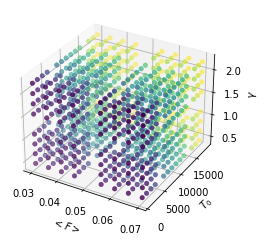

In [4]:
# Filter out repeated data
final_params = []
final_corr = []
count = 0
for idx, data in enumerate(final_samples):
    for i in final_params:
        if np.array_equal(data,i):
            count += 1
    if count == 0:
        final_params.append(data)
        final_corr.append(models[idx,:])
    count = 0
final_samples = np.asarray(final_params)
models = np.asarray(final_corr)
print(final_samples.shape)

dir = '/home/zhenyujin/igm_emulator/igm_emulator/emulator/GRID'
num = f'_training_{models.shape[0]}'
dill.dump(final_samples,open(os.path.join(dir, f'{z_string}_param{num}.p'),'wb'))
dill.dump(models,open(os.path.join(dir, f'{z_string}_model{num}.p'),'wb'))

H = final_samples
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(H[:, 0], H[:, 1], H[:, 2], c =H[:, 1], cmap='viridis', linewidth=0.5)
ax.set_xlabel(r'$<F>$')
ax.set_ylabel(r'$T_0$')
ax.set_zlabel(r'$\gamma$')
plt.savefig("params.png")
plt.show()

(383, 281)
(383, 3)


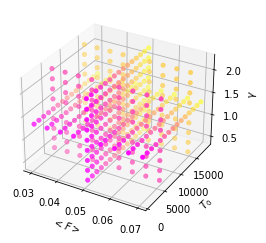

tf.Tensor(
[False False False False False False False False  True  True False False
  True False False False  True False False  True False False False False
 False False False  True  True False False False  True False False False
 False  True  True False False False False False False  True  True  True
 False False False False False  True False False  True False False False
 False False False False False False False False False False False False
 False False  True False False  True False False False  True False False
 False False False False False False False False False False False  True
  True False False False False False False False False False False False
 False False False False False  True False False False False False False
 False  True False  True  True False  True False False False False  True
 False  True False False False False False False False False  True False
 False False  True False False  True False  True False False False False
 False  True False  True False False Fal

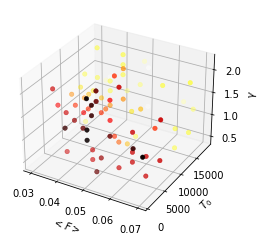

In [5]:
# Test data
test_param = []
test_corr = []
for idx, data in enumerate(all_data):
    count = 0
    for i in final_samples:
        if np.array_equal(data,i):
            count += 1
            break
        else:
            pass
    if count == 0:
        test_param.append(data)
        fobs_idx = np.argmin(np.abs(fobs - data[0]))
        T0_idx = np.argmin(np.abs(T0s - data[1]))
        gamma_idx = np.argmin(np.abs(gammas - data[2]))

        # get the corresponding model autocorrelation for each parameter location
        like_name = f'likelihood_dicts_R_30000_nf_9_T{T0_idx}_G{gamma_idx}_SNR0_F{fobs_idx}_ncovar_500000_P{n_path}_set_bins_4.p'
        like_dict = dill.load(open(in_path + like_name, 'rb'))
        model_autocorrelation = like_dict['mean_data']
        test_corr.append(model_autocorrelation)
test_param = np.asarray(test_param)
test_corr = np.asarray(test_corr)
print(test_corr.shape)
print(test_param.shape)

A = test_param
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(A[:, 0], A[:, 1], A[:, 2], c =A[:, 1], cmap='spring', linewidth=0.5)
ax.set_xlabel(r'$<F>$')
ax.set_ylabel(r'$T_0$')
ax.set_zlabel(r'$\gamma$')
plt.savefig("params.png")
plt.show()

n_testing = round(test_corr.shape[0] * 0.2)
n_validation = round(test_corr.shape[0] * 0.8)


test_selection = tf.random.shuffle([True]*n_testing+[False]*n_validation)#, lambda:random.gauss(0.5,0.1))

#test_selection =  1 >= test_selection
print(test_selection)


vali_param, vali_corr = test_param[~test_selection], test_corr[~test_selection]
testing_param, testing_corr = test_param[test_selection], test_corr[test_selection]
print(vali_param.shape)
print(testing_param.shape)

T = testing_param
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(T[:, 0], T[:, 1], T[:, 2], c =T[:, 1], cmap='hot', linewidth=0.5)
ax.set_xlabel(r'$<F>$')
ax.set_ylabel(r'$T_0$')
ax.set_zlabel(r'$\gamma$')
plt.savefig("params.png")
plt.show()


In [6]:
test_num=f'_test_{testing_param.shape[0]}'
dill.dump(testing_param,open(os.path.join(dir, f'{z_string}_param{test_num}.p'),'wb'))
dill.dump(testing_corr,open(os.path.join(dir, f'{z_string}_model{test_num}.p'),'wb'))

vali_num=f'_vali_{vali_param.shape[0]}'
dill.dump(vali_param,open(os.path.join(dir, f'{z_string}_param{test_num}.p'),'wb'))
dill.dump(vali_corr,open(os.path.join(dir, f'{z_string}_model{test_num}.p'),'wb'))
print('vali saved')

vali saved
